# Quality control

In th EB dataset: for the diving event 2016/2017 cut out the data from 100m and set to 250m and then replace the 100m values with nans

... don't really need this script anymore since I am doing this step in the Mooring-data script now

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
import xarray as xr
import cmocean as cm
import marineHeatWaves as mhw
from datetime import date

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
file_name = "data/rteb1_all_merged_new.nc"
ds_eb = xr.open_dataset(file_name)

In [4]:
file_name = "data/rteb_oxy_1D.nc"
ds_ox = xr.open_dataset(file_name)

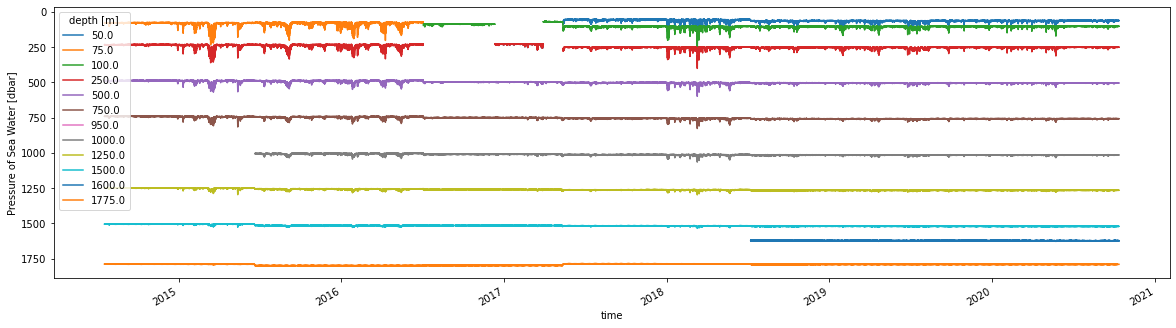

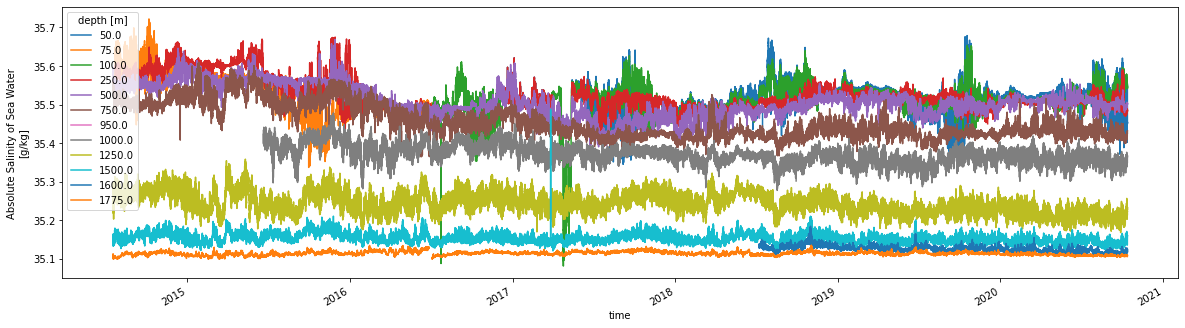

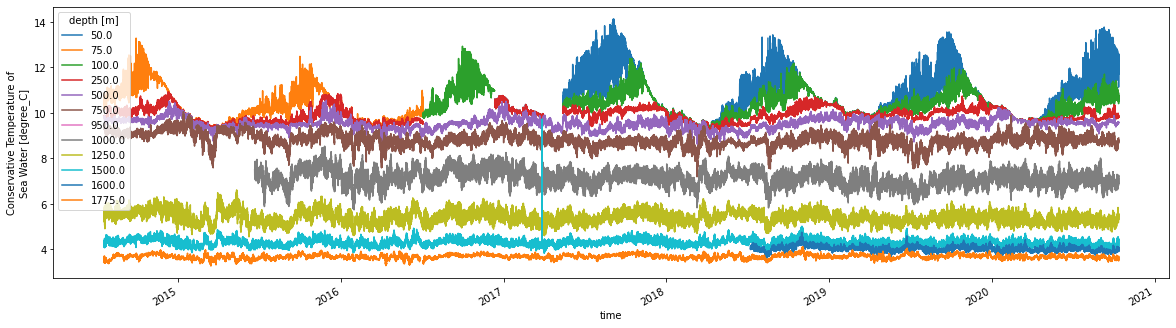

In [5]:
ds_eb.pres.plot.line(x='time', figsize = (20,5), yincrease = False); #.where(ds.pres>0);
ds_eb.sal.where(ds_eb.sal>0).plot.line(x='time', figsize = (20,5));
ds_eb.temp.plot.line(x='time', figsize = (20,5));

# seems fine, just need to fix 2017

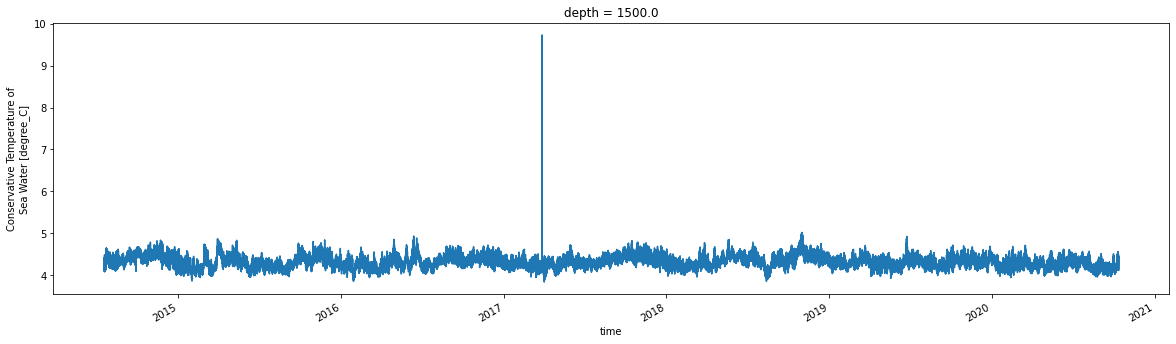

In [6]:
ds_eb.temp.sel(depth=1500).plot.line(x='time', figsize = (20,5));

In [7]:
# ds_eb1500 = ds_eb.sel(depth = 1500)
# ds_eb1500t = ds_eb1500.temp.where(ds_eb.temp.sel(depth = 1500)<5)

# ds_eb1500 = ds_eb1500.drop_vars('temp')
# ds_eb1500 = xr.merge([ds_eb1500, ds_eb1500t])

In [8]:
#ds_eb = ds_eb.drop_sel(depth=1500)

In [9]:
#ds_eb = xr.concat([ds_eb, ds_eb1500], dim = 'depth')

## Create mask file to get rid bad data BEFORE resampling

Forget what I said about keeping the mask file in the resampled data. We want to get rid of the bad before we do the resampling because we do not want the bad data to falsify the 1D data. I.e. in the 1D data we only use good data and no mask is required any more. I use a numpy array instead xarray to manipulate only the first colum of the array (which is not possible in xarray...). I think the is the best way to do it.

In [10]:
mask=(ds_eb.pres>0) & (ds_eb.pres.notnull()) & (ds_eb.temp.sel(depth = 1500)<5)
mask = mask.values
mask[0] = ds_eb.sel(depth=50).pres<200
ds_eb = ds_eb.where(mask)

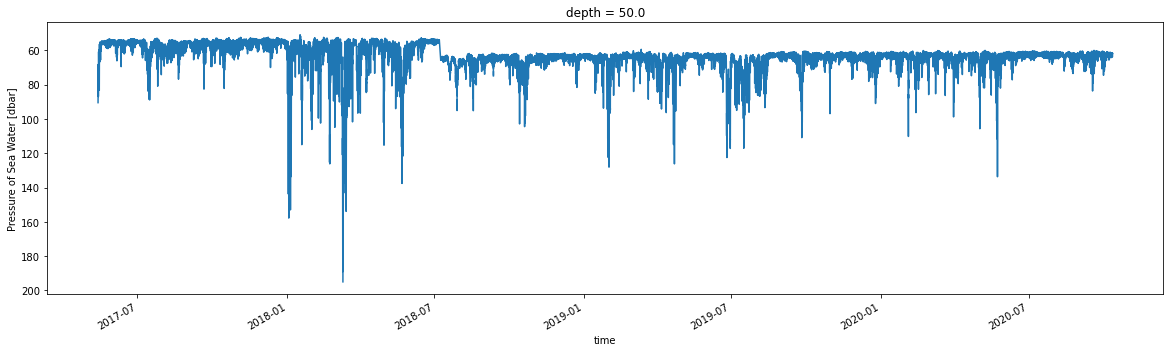

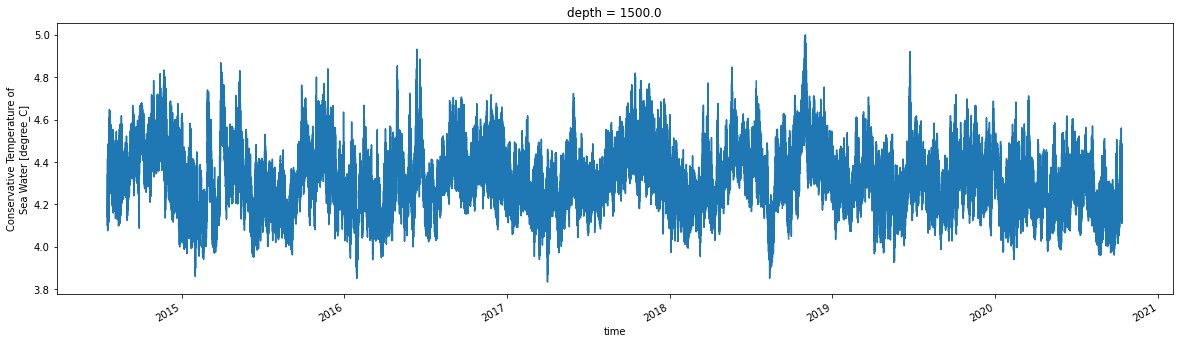

In [11]:
ds_eb.pres.sel(depth=50).plot.line(x='time', figsize = (20,5), yincrease = False);
ds_eb.temp.sel(depth=1500).plot.line(x='time', figsize = (20,5));

In [12]:
ds_eb = ds_eb.resample(time = "1D").mean(keep_attrs=True);

In [13]:
ds_eb = xr.concat([ds_eb, ds_ox], dim = 'moor')

In [14]:
ds_eb = ds_eb.mean('moor', keep_attrs=True)

In [15]:
ds_eb

<xarray.Dataset>
Dimensions:  (depth: 12, time: 2279)
Coordinates:
  * depth    (depth) float64 50.0 75.0 100.0 250.0 ... 1.5e+03 1.6e+03 1.775e+03
  * time     (time) datetime64[ns] 2014-07-18 2014-07-19 ... 2020-10-12
Data variables:
    oxy      (time, depth) float64 nan nan nan nan nan ... nan nan nan nan nan
    temp     (time, depth) float64 nan 10.45 nan 9.842 ... 5.43 4.29 3.961 3.6
    pres     (time, depth) float64 nan 78.23 nan ... 1.623e+03 1.79e+03
    sal      (time, depth) float64 nan 35.56 nan 35.56 ... 35.15 35.12 35.11
Attributes:
    Mooring:          rteb1
    WaterDepth:       1800
    Start_Date:       2014/07/18
    Start_Time:       12:30
    End_Date:         2015/06/20
    End_Time:         06:30
    Latitude:         57.099333333333334
    Longitude:        -9.548
    Latitude_units:   degrees_north
    Longitude_units:  degrees_east

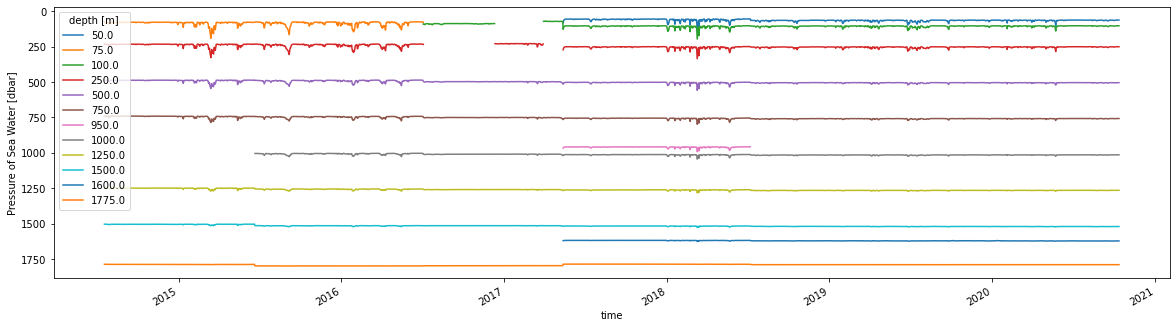

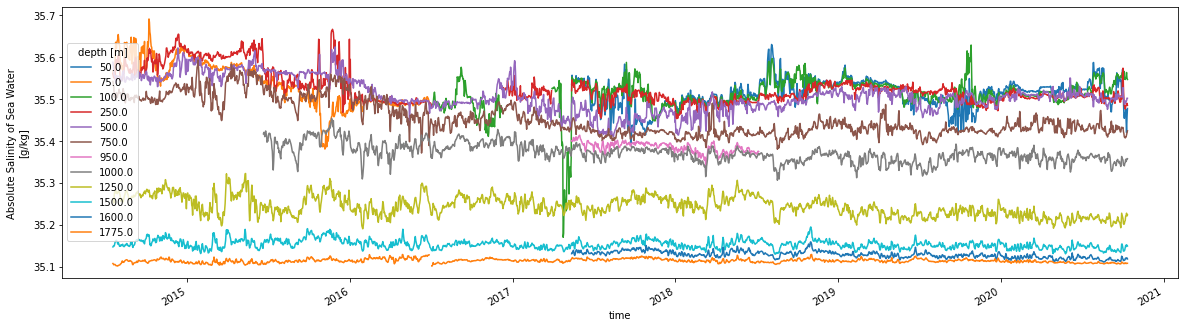

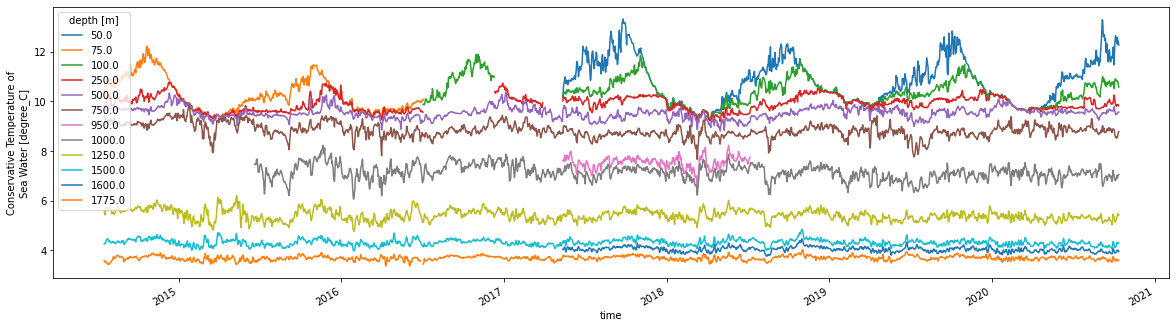

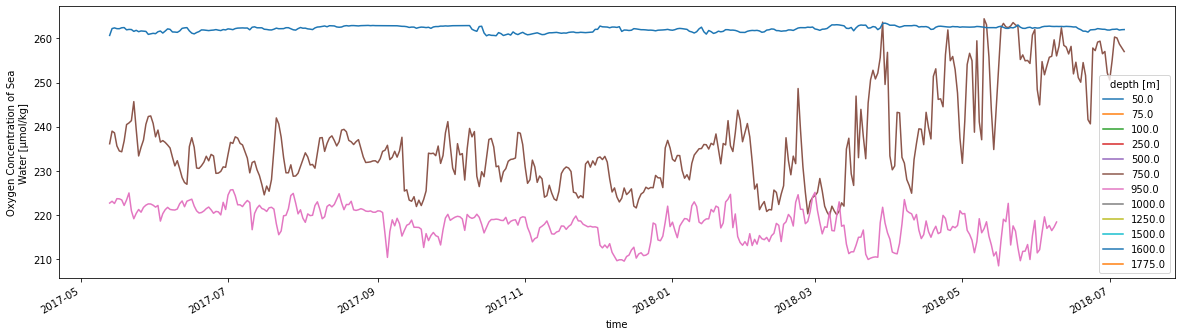

In [16]:
ds_eb.pres.plot.line(x='time', figsize = (20,5), yincrease = False); #.where(ds.pres>0);
ds_eb.sal.plot.line(x='time', figsize = (20,5));
ds_eb.temp.plot.line(x='time', figsize = (20,5));
ds_eb.oxy.plot.line(x='time', figsize = (20,5));

In [17]:
ds_eb.to_netcdf('data/rteb_all_1D.nc', 
       engine='netcdf4',
       encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})

In [18]:
# ## this is now done in Mooring_data.ipynb
# # save so I can drop and concat them later ... to stop them from interfearing with the process...
# ds_eb75=ds_eb.sel(depth=75) 
# ds_eb950=ds_eb.sel(depth=950)
# ds_eb755=ds_eb.sel(depth=755)
# ds_eb1000=ds_eb.sel(depth=1000) 
# ds_eb1600=ds_eb.sel(depth=1600) 


# # 250 m data put in 100m data into 250m data for duratio of the knock down event
# eb_dive = ds_eb.sel(depth=100).where(ds_eb.pres.sel(depth=100)>220) #, time = slice('2016-10-1', '2017-4-30')
# eb_dive.update({'depth':('depth', [250])});
# ds_eb=ds_eb.fillna(value=eb_dive)

# ds_eb250=ds_eb.sel(depth=250)

# ds_eb=ds_eb.drop_sel(depth=[75])
# ds_eb=ds_eb.drop_sel(depth=[250])
# ds_eb=ds_eb.drop_sel(depth=[755])
# ds_eb=ds_eb.drop_sel(depth=[950])
# ds_eb=ds_eb.drop_sel(depth=[1000])
# ds_eb=ds_eb.drop_sel(depth=[1600])

# # 100m data remove pressure spike and temp spike
# ds_eb100 = ds_eb.sel(depth=100).where(((ds_eb.time<np.datetime64('2016-12-11')) | (ds_eb.time>np.datetime64('2017-03-30'))))
# ds_eb100t = ds_eb100.temp.where(((ds_eb.time<np.datetime64('2017-03-30')) | (ds_eb.time>np.datetime64('2017-05-31'))))

# ds_eb100 = ds_eb100.drop_vars('temp')
# ds_eb100 = xr.merge([ds_eb100,ds_eb100t])
# ds_eb = ds_eb.drop_sel(depth=[100])

# # concat all together
# ds_eb = xr.concat([ds_eb, ds_eb75, ds_eb100, ds_eb250, ds_eb755, ds_eb950, ds_eb1000, ds_eb1600], dim='depth')
# ds_eb = ds_eb.sortby(ds_eb.depth)

# #plot results
# ds_eb.pres.plot.line(x='time', figsize = (20,5), yincrease = False);
# ## checking that 100m temperature no longer has weird spike
# ds_eb.temp.sel(depth = 100).plot.line(x='time', figsize = (20,5));